# Preliminaries
First install a critical dependency for our code

In [1]:
!pip install keras==2.2.4 # critical dependency, 

     |████████████████████████████████| 317kB 1.3MB/s 
  Found existing installation: Keras 2.3.0
    Uninstalling Keras-2.3.0:
      Successfully uninstalled Keras-2.3.0


Write requirements to file, anytime you run it, in case you have to go back and recover dependencies.

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [2]:
!pip freeze > kaggle_image_requirements.txt

# Read and Preprocess Fake News Dataset
First let's list the available data files

In [3]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


Read in the "true" and "fake" data

In quotes, because that has the potential to simply replicate the biases of the labeler, so should be carefully evaluated

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Read the data into pandas DataFrames
DataTrue = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
DataFake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

print("Data labeled as True:")
print(DataTrue.head())
print("\n\n\nData labeled as Fake:")
print(DataFake.head())

Data labeled as True:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   



Data labeled as Fake:
                                               titl

Assemble the two different kinds of data

In [5]:
Nsamp =1000 # number of samples to generate in each class - 'true', 'fake'
DataTrue = DataTrue.sample(Nsamp)
DataFake = DataFake.sample(Nsamp)
raw_data = pd.concat([DataTrue,DataFake], axis=0).values

# combine title, body text and topics into one string per document
raw_data = [sample[0].lower() + sample[1].lower() + sample[3].lower() for sample in raw_data]

print("Length of combined data is:")
print(len(raw_data))
print("Data represented as numpy array (first 5 samples) is:")
print(raw_data[:5])

# corresponding labels
Categories = ['True','False']
header = ([1]*Nsamp)
header.extend(([0]*Nsamp))

Length of combined data is:
2000
Data represented as numpy array (first 5 samples) is:
['eleven injured in car crash near london museum, terrorism ruled outlondon (reuters) - eleven people were injured on saturday when a car collided with pedestrians near london s natural history museum, in one of the capital s busiest tourist areas, but police doused concerns it was a terrorist attack, saying it was a road traffic incident.  police said it was believed the car had mounted the pavement outside the popular attraction in west london and collided with a number of pedestrians.  officers had arrested a man aged in his 40s at the scene and he was now being questioned on suspicion of dangerous driving after being taken to hospital for treatment. britain has suffered five attacks blamed on terrorism so far this year, three of which involved vehicles, and the incident in an area packed with tourists at the weekend had prompted concerns that the collision had been a deliberate act.  the incident

Shuffle data, split into train and test sets...

In [6]:
# function for shuffling data
def unison_shuffle(a, b):
    p = np.random.permutation(len(b))
    data = np.asarray(a)[p]
    header = np.asarray(b)[p]
    return data, header

raw_data, header = unison_shuffle(raw_data, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7*raw_data.shape[0])

# 70% of data for training
train_x = raw_data[:idx]
train_y = header[:idx]
# remaining 30% for testing
test_x = raw_data[idx:]
test_y = header[idx:]

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
#print(train_x)
print(train_y[:5])
print(train_y.shape)

train_x/train_y list details, to make sure it is of the right form:
1400
[0 1 0 0 1]
(1400,)


# Build, Train and Evaluate ELMo Model

First import required neural network libraries



In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer

# Initialize tensorflow/keras session
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


Create a custom tf hub ELMO embedding layer

In [8]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024 # initialize output dimension of ELMo embedding
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape): # function for building ELMo embedding
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name)) # download pretrained ELMo model
        
        # extract trainable parameters, which are only a small subset of the total - this is a constraint of
        # the tf hub module as shared by the authors - see https://tfhub.dev/google/elmo/2
        # the trainable parameters are 4 scalar weights on the sum of the outputs of ELMo layers 
        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None): # specify function for calling embedding
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_output_shape(self, input_shape): # specify output shape
        return (input_shape[0], self.dimensions)

We now use the custom TF hub ELMo embedding layer within a higher-level function to define the overall model. More specifically, we put a dense trainable layer of output dimension 256 on top of the ELMo embedding.

In [9]:
# Function to build overall model
def build_model():
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    dense = layers.Dense(256, activation='relu')(embedding)
    pred = layers.Dense(1, activation='sigmoid')(dense)    
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [10]:
print(train_x.shape)

(1400,)


In [11]:
# Build and fit

model = build_model()
history = model.fit(train_x, 
          train_y,
          validation_data=(test_x, test_y),
          epochs=10,
          batch_size=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 262,661
Trainable params: 262,661
Non-trainable params: 0
_________________________________________________________________
Train on 1400 samples, validate on 600 samples
Epoch 1/10
1400/1400 [==============================] - 886s 633ms/step - loss: 0.3693 - acc: 0.8907 - val_loss: 0.1621 - val_acc: 0.9433
Epoch 2/10
1400/1400 [==============================] - 856s 612ms/step - loss: 0.1

Save trained model

In [12]:
model.save('ELMoModel.h5')

Visualize Convergence

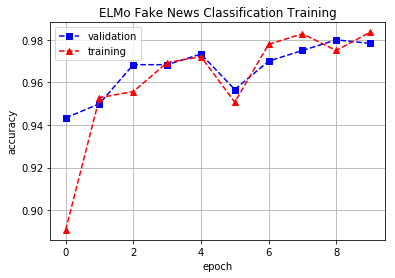

In [13]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(history.history)

fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_acc'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['acc'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ELMo Fake News Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()
# Save figures
fig.savefig('ELMoConvergence.eps', format='eps')
fig.savefig('ELMoConvergence.pdf', format='pdf')
fig.savefig('ELMoConvergence.png', format='png')
fig.savefig('ELMoConvergence.svg', format='svg')

Make figures downloadable to local system in interactive mode

In [14]:
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='ELMoConvergence.svg')